# Lynch Syndrome CRC calibration
Author: Sophie Wagner <br>
Contact: sw3767@cumc.columbia.edu

## Notebook configuration

In [1]:
import sys
import os
from collections import defaultdict

import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps  # For smoothing splines
from scipy.interpolate import interp1d # For interpolation
from tqdm import tqdm  # For progress bars


sys.path.append(os.path.abspath("../src"))

# Remove previously imported modules to ensure fresh imports
for m in ["helpers", "calibration", "configs"]:
    if m in sys.modules:
        del sys.modules[m]

import helpers
import calibration
import configs.global_configs as c
import configs.inputs as inputs
import helpers.common_functions as func
import calibration.plots as pl
import calibration.gof as gof

# Some aesthetic options
helpers.add_cell_timer()
np.set_printoptions(
    suppress=True, linewidth=300, formatter={"float": "{: 0.9f}".format}
)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

## Load inputs

In [2]:
# Lifetables (monthly ACM rate in 5-year age groups)
lt_f = inputs.lt_5y["prob_death_female_m"].iloc[4:17]
lt_m = inputs.lt_5y["prob_death_male_m"].iloc[4:17]
lt_f = np.array(lt_f)
lt_m = np.array(lt_m)

# Starting population vector
c.GENES = ["PMS2"]
GENE = "PMS2"
c.n_genes = 1 
starting_pop = np.zeros((len(c.SEXES),c.n_states,1))
starting_pop[:,0,:] = c.POPULATION_SIZE


In [75]:
# Targets

# NCCN: Target incidence RANGE by age 80. By Gene. 
target_inc_80 = inputs.incidence_by_80_target 

# NCCN: Cumulative CRC incidence through age 70, by gene and sex (no PMS2)
target_inc_70 = inputs.incidence_by_70_target

# NCCN: Median age at CRC diagnosis. Range for MSH6 and PMS2, value for MLH1 and MSH2. all sexes. 
target_median_age = inputs.median_age_at_dx_target

# Stage distribution (ensure 4-long vector in stage_1..stage_4 order)
target_stage_dist = (
    inputs.stage_dist_target
    .sort_values("stage")["value"]
    .to_numpy()
)

# (Myles) Adenoma by 65. by gene, all sexes
target_polyp = inputs.polyp_target

# PLSD: Target incidence by age 65. By Sex and Gene. UNDER SURVEILLANCE
target_inc_65 = inputs.incidence_by_65_target

# CRC incidence rate UNDER SURVEILLANCE by gene and sex and age. 
# This should inform the curve/slope of development, values of model may be skewed more to the NCCN targets. 
target_inc_cumulative = inputs.incidence_cumulative_target
# Access like: target_inc_cumulative.loc[('MLH1','female')]

In [76]:
print("Target inc 80-------------------------")
print(target_inc_80)
print("\nTarget inc 70-------------------------")
print(target_inc_70)
print("\nTarget inc 65-------------------------")
print(target_inc_65)


Target inc 80-------------------------
      lower  upper  ref
gene                   
MLH1  0.460   0.61  103
MSH2  0.330   0.52  103
MSH6  0.100   0.44  103
PMS2  0.087   0.20  103

Target inc 70-------------------------
             value  lower  upper        se       var
gene sex                                            
MLH1 male    0.439  0.396  0.466  0.017857  0.000319
MSH2 male    0.539  0.490  0.563  0.018622  0.000347
MSH6 male    0.120  0.024  0.246  0.056633  0.003207
MLH1 female  0.373  0.322  0.402  0.020408  0.000416
MSH2 female  0.386  0.341  0.420  0.020153  0.000406
MSH6 female  0.123  0.035  0.232  0.050255  0.002526

Target inc 65-------------------------
             value  lower  upper        se       var     n
gene sex                                                  
MLH1 male    0.484  0.424  0.548  0.031633  0.001001  1445
MSH2 male    0.415  0.348  0.488  0.035714  0.001276  1463
MSH6 male    0.127  0.068  0.231  0.041582  0.001729   765
PMS2 male    0.095

In [77]:
print("Target median age------------------------------")
print(target_median_age)
print("\nTarget polyp prevalence----------------------")
print(target_polyp)
print("\nTarget cumulative inc------------------------")
print(target_inc_cumulative.head())
print("\nTarget stage distribution--------------------")
print(target_stage_dist)

Target median age------------------------------
      value  lower  upper  refs
gene                           
MLH1   44.0    NaN    NaN   103
MSH2   44.0    NaN    NaN   103
MSH6    NaN   42.0   69.0   103
PMS2    NaN   61.0   66.0   103

Target polyp prevalence----------------------
       value
gene        
MLH1  0.6809
MSH2  0.5836
MSH6  0.6181
PMS2  0.6181

Target cumulative inc------------------------
                 value  lower  upper     n        se       var
gene sex    age                                               
MLH1 female 30   0.000    NaN    NaN  1686  0.041934  0.001758
            40   0.090  0.063  0.128  1686  0.016582  0.000275
            50   0.182  0.145  0.228  1686  0.021173  0.000448
            60   0.306  0.258  0.361  1686  0.026276  0.000690
            70   0.421  0.362  0.486  1686  0.031633  0.001001

Target stage distribution--------------------
[ 0.400000000  0.360000000  0.190000000  0.050000000]


## Matrix configuration

In [92]:
def row_normalize(matrix):
    matrix = np.clip(matrix, 0.0, 0.5)
    # Iterate over the first three dimensions to access each (n_states, n_states) matrix
    for sex in range(matrix.shape[0]):
        for age_layer in range(matrix.shape[1]): 
            layer = matrix[sex, age_layer]
            # # Calculate the sum of non-diagonal elements for each row
            # sum_of_rows = np.sum(layer, axis=1) - np.diag(layer)
            # # Set the diagonal elements
            # np.fill_diagonal(layer, np.maximum(1 - sum_of_rows, 0.0))
            
            row_sums_off = layer.sum(axis=1) - np.diag(layer)
            # If off-diagonals > 1, rescale them down to sum to (1 - eps)
            too_big = row_sums_off > 1 - 1e-12
            if np.any(too_big):
                scale = (1 - 1e-8) / row_sums_off[too_big]
                layer[too_big] *= scale[:, None]   # scale whole row
                # restore zeros back on diag before fill
                np.fill_diagonal(layer, 0.0)
                row_sums_off = layer.sum(axis=1) - np.diag(layer)
            np.fill_diagonal(layer, np.maximum(1 - row_sums_off, 0.0))
                
    return matrix


def row_normalize(matrix, protected_targets=(12,)):
    """
    Normalize each row so it sums to 1 without rescaling protected targets
    (e.g., ACM in column 12). Only non-protected off-diagonals are scaled.
    The diagonal is set to the remaining mass.
    """
    S, A, N, _ = matrix.shape
    clip_max = 0.5
    eps = 1e-8
    
    # convenience column mask for non-protected targets
    col_mask_nonprot = np.ones(N, dtype=bool)
    if protected_targets:
        col_mask_nonprot[list(protected_targets)] = False

    for s in range(S):
        for a in range(A):
            layer = matrix[s, a]  # shape (N, N)

            # clip only non-protected, non-diagonal entries
            # (leave protected targets exactly as set from life table)
            nonprot_off = np.ones_like(layer, dtype=bool)
            np.fill_diagonal(nonprot_off, False)
            if protected_targets:
                nonprot_off[:, list(protected_targets)] = False
            layer[nonprot_off] = np.clip(layer[nonprot_off], 0.0, clip_max)

            # sums per row
            fixed_sum = layer[:, list(protected_targets)].sum(axis=1) if protected_targets else 0.0
            # exclude diagonal and protected from the "rescalable" pool
            other_off_sum = layer.sum(axis=1) - np.diag(layer) - fixed_sum

            # how much probability mass remains for rescalables
            cap = 1.0 - eps - fixed_sum
            cap = np.maximum(cap, 0.0)  # guard

            # rows where rescalables overflow their cap → scale *only* rescalables
            too_big = other_off_sum > cap + 1e-15
            if np.any(too_big):
                scale = np.ones(N)
                scale[too_big] = cap[too_big] / other_off_sum[too_big]

                # scale non-protected off-diagonals row-wise
                # (vectorized per-row scaling on selected columns)
                matrix[s, a][np.ix_(too_big, col_mask_nonprot)] *= scale[too_big, None]

                # recompute other_off_sum after scaling for those rows
                layer = matrix[s, a]
                other_off_sum = layer.sum(axis=1) - np.diag(layer) - fixed_sum

            # finally, close the diagonal with remaining mass
            diag_vals = 1.0 - (fixed_sum + other_off_sum)
            diag_vals = np.maximum(diag_vals, 0.0)
            layer[np.arange(N), np.arange(N)] = diag_vals

            # write back (layer already references matrix[s, a], so not strictly needed)
            matrix[s, a] = layer

    return matrix


def create_matrix():
    # Initialize matrix 2 x 4 x n_age_layers x n_states x n_states
    # This gives us a n_states x n_states matrix for each age layer for each gene-gender combination
    matrix = np.zeros(
        (len(c.SEXES), len(c.AGE_LAYERS), c.n_states, c.n_states)
    )

    matrix[:, :, 0, 1] = func.probtoprob(0.0711249)  # healthy to lr_polyp
    matrix[:, :, 1, 2] = func.probtoprob(0.20936037)  # lr_polyp to hr_polyp
    matrix[:, :, 2, 3] = func.probtoprob(0.44650303)  # hr_polyp to u_stage_1
    matrix[:, :, 3, 4] = func.probtoprob(0.20)  # u_stage_1 to u_stage_2
    matrix[:, :, 4, 5] = func.probtoprob(0.40)  # u_stage_2 to u_stage_3
    matrix[:, :, 5, 6] = func.probtoprob(0.50)  # u_stage_3 to u_stage_4
    matrix[:, :, 3, 7] = func.probtoprob(0.30)  # u_stage_1 to d_stage_1
    matrix[:, :, 4, 8] = func.probtoprob(0.50)  # u_stage_2 to d_stage_2
    matrix[:, :, 5, 9] = func.probtoprob(0.60)  # u_stage_3 to d_stage_3
    matrix[:, :, 6, 10] = func.probtoprob(0.70)  # u_stage_4 to d_stage_4

    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix


def constrain_matrix(matrix):

    # Progression Block
    matrix[:, :, 0, 1] = np.maximum(0.000001, matrix[:, :, 0, 1])  # not below 0
    matrix[:, :, 1, 2] = np.maximum(matrix[:, :, 0, 1], matrix[:, :, 1, 2])
    matrix[:, :, 2, 3] = np.maximum(matrix[:, :, 1, 2], matrix[:, :, 2, 3])
    # Cancer progression
    matrix[:, :, 3, 4] = np.maximum(0.001, matrix[:, :, 3, 4])  # not below 0
    matrix[:, :, 4, 5] = np.maximum(matrix[:, :, 3, 4], matrix[:, :, 4, 5])
    matrix[:, :, 5, 6] = np.maximum(matrix[:, :, 5, 6], matrix[:, :, 4, 5])

    # Detection Block
    matrix[:, :, 3, 7] = np.maximum(0.001, matrix[:, :, 3, 7])  # not below 0
    matrix[:, :, 4, 8] = np.maximum(matrix[:, :, 3, 7], matrix[:, :, 4, 8])
    matrix[:, :, 5, 9] = np.maximum(matrix[:, :, 4, 8], matrix[:, :, 5, 9])
    matrix[:, :, 6, 10] = np.maximum(matrix[:, :, 5, 9], matrix[:, :, 6, 10])

    # Age dependencies
    for s in range(c.n_sexes):
        matrix[s, :, 0, 1] = np.maximum.accumulate(matrix[s, :, 0, 1]) # healthy to lr_polyp
        # matrix[s, :, 3, 7] = np.maximum.accumulate(matrix[s, :, 3, 7])
        # matrix[s, :, 4, 8] = np.maximum.accumulate(matrix[s, :, 4, 8])
        # matrix[s, :, 5, 9] = np.maximum.accumulate(matrix[s, :, 5, 9])
        # matrix[s, :, 6,10] = np.maximum.accumulate(matrix[s, :, 6,10])
    
    # Male prevalence is higher, assume through this transition
    matrix[0, :, 0, 1] = np.maximum(matrix[0,:,0,1], matrix[1,:,0,1])
    matrix[0, :, 1, 2] = np.maximum(matrix[0,:,1,2], matrix[1,:,1,2])

    return matrix


def add_acm(matrix):
    for sex, lt in enumerate([lt_m, lt_f]):
        matrix[sex, :, :11, 12] = lt[:, np.newaxis]  # ACM (13,1) -> (13,11)
        matrix[sex, :, 11, 11] = 1  # Stay in CSD
        matrix[sex, :, 12, 12] = 1  # Stay in ACM
        matrix[sex, :, 13, 13] = 1  # Stay in Colo death (unused during calibration)
    return matrix


def add_csd(matrix):
    matrix[:, :, 7, 11] = func.probtoprob(0.05)
    matrix[:, :, 8, 11] = func.probtoprob(0.19)
    matrix[:, :, 9, 11] = func.probtoprob(0.75)
    matrix[:, :, 10, 11] = func.probtoprob(0.90)
    return matrix

## Markov model

In [79]:
def run_markov(tmat, starting_age=20, max_age=84):
    
    current_age = starting_age
    stage, age_layer_idx = 1, 0
    pop_log   = starting_pop.copy()  # (2, 14, 1) at t=0
    month_pop = starting_pop.copy() # (2, 14, 1) at t=0
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    n_years = max_age - starting_age + 1 

    # Initial matrix is (2, A, 14, 14) (SEX, AGE_GROUP, HEALTH_STATE, HEALTH_STATE)
    # Transpose health state sub-matrix s.t. we get inverted matrix for multiplication
    tmat_T = tmat.transpose(0,1,3,2) # (2, A, 14, 14)
    inflow_tmat = np.tril(tmat_T, k=-1) # lower triangle, exclude diag -> inflows
    
    while current_age <= max_age:
        
        # Matrix multiplication (state transition) -- batched for each sex 
        month_inc = np.matmul(inflow_tmat[:,age_layer_idx,:,:], month_pop)  # (2, 14, 14)(2, 14, 1)->(2, 14, 1)
        month_pop = np.matmul(tmat_T[:,age_layer_idx,:,:], month_pop)  # (2, 14, 14)(2, 14, 1)->(2, 14, 1)
        
        # append along time axis
        inc_log = np.concatenate((inc_log, month_inc), axis=2)  # (2,14,T)
        pop_log = np.concatenate((pop_log, month_pop), axis=2)  # (2,14,T)
        
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            if current_age in c.AGE_LAYERS.keys(): 
                age_layer_idx = age_layer_idx+1

    # Adjustment: incidence and prevalence should be out of living only
    # dead states are indices 11,12,13 → sum over STATE axis (axis=1) to get (sex, time)
    dead_counts = pop_log[:, 11:, :].sum(axis=1)  # (2, T)
    alive = np.maximum(c.POPULATION_SIZE - dead_counts, 1e-12)  # (2, T)
    dead_factor = (c.POPULATION_SIZE / alive)                   # (2, T)
    
    prevalence_adj = np.zeros_like(pop_log)  # (2, 14, T)
    incidence_adj, incidence_unadj = inc_log.copy(), inc_log.copy() # both (2,14,T)

    for state in range(c.n_states):
        incidence_adj[:, state, :]  = inc_log[:, state, :]  * dead_factor
        prevalence_adj[:, state, :] = pop_log[:, state, :]  * dead_factor

    # Transform into annual counts. For incidence, we sum; for prevalence, we average. 
    incidence_unadj = incidence_unadj.reshape(c.n_sexes, c.n_states, n_years, 12).sum(axis=-1) # getting inc unadjusted
    incidence_adj   = incidence_adj.reshape(c.n_sexes, c.n_states, n_years, 12).sum(axis=-1) # getting annual incidence (rate per 100k alive)
    prevalence_adj  = prevalence_adj.reshape(c.n_sexes, c.n_states, n_years, 12).mean(axis=-1) # getting mean annual prevalence
    
    return incidence_adj, prevalence_adj, incidence_unadj, pop_log

## Calibration

### Step function
1. Select random combination of (sex, gene, age layer, transition prob)
2. Take a random step (using step size) to adjust the selected transition probability
3. (Optional / later into calibration) Spline across age groups such that we don't get too abnormal of a value / smoother transitions across age
4. Check matrix constraints

In [80]:
calibration_tps = list(c.calibration_tps_itos.keys())
n_calibration_tps = len(calibration_tps)
age_mids = [22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5]

def step(matrix, step_size, num_adj=10, smooth=0.01):
    new_matrix = np.copy(matrix)
    step_tp = np.random.choice(n_calibration_tps, size=num_adj, replace=True)
    step_age = np.random.choice(c.n_age_layers, size=num_adj, replace=True)
    step_sex = np.random.choice(c.n_sexes, size=num_adj, replace=True)

    for i in range(num_adj):
        (from_state, to_state) = calibration_tps[step_tp[i]]
        if (from_state,to_state) in [(0,1), (1,2)]: # only Healthy -> LR -> HR may differ
            new_matrix[step_sex[i], step_age[i], from_state, to_state] += np.random.uniform(low=-step_size, high=step_size)
        else:
            new_matrix[:, step_age[i], from_state, to_state] += np.random.uniform(low=-step_size, high=step_size)
    
    # Limit potential increase before splining across ages 
    new_matrix[:,c.n_age_layers-1,:,:] = np.minimum(new_matrix[:,c.n_age_layers-2,:,:],new_matrix[:,c.n_age_layers-1,:,:])  
    new_matrix = csaps(age_mids, new_matrix, smooth=smooth, axis=1)(age_mids).clip(0.0,1.0)
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

### Objective function (goodness of fit)
Here, we calculate how far off we are from our model targets, and produce a goodness-of-fit score. This is calculated by the mean-squared error between the model output and the target (i.e. mean((prediction-target)**2)). Our calibration targets are:
1. Stage distribution at diagnosis -- from Myles
2. Cumulative CRC incidence by gene and sex -- from Dominguez et al 2024 splined curves (see "data cleaning" folder)
3. Cumulative adenoma risk by gene at age 60 -- from Myles

In [81]:
from typing import Any, cast
stage_idx = [7, 8, 9, 10]  # stage_1..stage_4

def w_hinge(y, lo, hi, var=None, n=None, huber_delta=None):
    """
    Zero loss if y in [lo,hi]. Otherwise squared distance outside the band.
    If huber_delta is set, use Huber outside the band.
    Weighting: prefer 1/var if provided, else 1/sqrt(n), else 1.
    """
    if lo is None or np.isnan(lo): lo = y  # force point loss if only hi given
    if hi is None or np.isnan(hi): hi = y

    if y < lo: r = lo - y
    elif y > hi: r = y - hi
    else: r = 0.0

    if huber_delta:
        a = abs(r)
        loss = 0.5*a*a if a <= huber_delta else huber_delta*(a - 0.5*huber_delta)
    else:
        loss = r*r

    if var is not None and var > 0:
        w = 1.0/var
    elif n is not None and n > 0:
        w = 1.0/np.sqrt(n)
    else:
        w = 1.0
    return w*loss


# Target stage distribution--------------------
# [ 0.400000000  0.360000000  0.190000000  0.050000000]
def obj_stage_divergence(log):
    inc_unadj = log[2]                                        # (sex, state, age)
    stage_totals_age = inc_unadj[:, stage_idx, :].sum(axis=0) # (4, A)
    total_crc_age    = np.maximum(stage_totals_age.sum(axis=0), 1e-12)  # (A,)
    p = stage_totals_age / total_crc_age[None, :]             # model (4,A)
    q = target_stage_dist[:, None]                            # target (4,1)

    # KL(q||p) averaged over ages, weighted by incident counts
    eps = 1e-10
    kl = np.sum(q * (np.log(np.maximum(q,eps)) - np.log(np.maximum(p,eps))), axis=0)  # (A,)
    w  = total_crc_age / total_crc_age.sum()
    return float(np.sum(w * kl))


def obj_stage_weighted(log):
    """
    Same as obj_stage, but weight ages by total CRC at that age.
    """
    inc_unadj = log[2]  # (sex, state, age)
    stage_totals_age = inc_unadj[:, stage_idx, :].sum(axis=0)  # (4, A)
    total_crc_per_age = np.maximum(stage_totals_age.sum(axis=0), 1e-12)  # (A,)

    denom = total_crc_per_age[None, :]  # (1, A)
    stage_props = stage_totals_age / denom  # (4, A)

    per_age_mse = ((stage_props - target_stage_dist[:, None])**2).mean(axis=0)  # (A,)

    w = total_crc_per_age / total_crc_per_age.sum()  # (A,)
    return float((per_age_mse * w).sum())

# Target inc 80-------------------------
#       lower  upper  ref
# gene                   
# MLH1  0.460   0.61  103
# MSH2  0.330   0.52  103
# MSH6  0.100   0.44  103
# PMS2  0.087   0.20  103
def obj_incidence_by_80(log):
    """
    Hinge loss to keep total cumulative incidence by 80 within [lower, upper].
    Compare proportions (not percent) across both sexes combined.
    """
    inc_unadj = log[2]
    age_80 = 80 - c.START_AGE

    # total incident cases to age 80 across sexes & stages
    total_cases = inc_unadj[:, stage_idx, :age_80].sum()  # scalar
    total_cases = inc_unadj[:, stage_idx, :age_80].sum()
    prop = total_cases / (float(c.POPULATION_SIZE) * float(c.n_sexes))

    row = target_inc_80.loc[GENE]
    lower, upper = row["lower"], row["upper"]
    mid = 0.5 * (lower + upper)
    var = ((upper - lower) / 3.92)**2
    under = max(0.0, lower - prop)
    over  = max(0.0, prop - upper)
    if under > 0:
        return (under**2) / var
    if over > 0:
        return (over**2) / var
    return 0.0

# Target inc 70-------------------------
#              value  lower  upper        se       var
# gene sex                                            
# MLH1 male    0.439  0.396  0.466  0.017857  0.000319
# MSH2 male    0.539  0.490  0.563  0.018622  0.000347
# MSH6 male    0.120  0.024  0.246  0.056633  0.003207
# MLH1 female  0.373  0.322  0.402  0.020408  0.000416
# MSH2 female  0.386  0.341  0.420  0.020153  0.000406
# MSH6 female  0.123  0.035  0.232  0.050255  0.002526
def obj_incidence_by_70(log):
    # No vals for PMS2 so use MSH6
    local_gene = "MSH6" if GENE == "PMS2" else GENE
        
    inc_unadj = log[2]
    age_70 = 70 - c.START_AGE
    
    # cumulative incident cases to 65 by sex (sum over stages & ages)
    model_inc_by_70 = inc_unadj[:, stage_idx, :age_70].sum(axis=(1, 2))  # (sex,)

    err = 0.0
    for s, sex in enumerate(c.SEXES):
        row = target_inc_70.loc[(local_gene, sex),:]
        target_val = row["value"]
        w = 1.0 / row["var"]
        if GENE == "PMS2":
            w /= 2.0 
        model_prop = model_inc_by_70[s] / float(c.POPULATION_SIZE)
        err += w * (model_prop - target_val) ** 2
    return float(err)
    
# Target inc 65-------------------------
#              value  lower  upper        se       var     n
# gene sex                                                  
# MLH1 male    0.484  0.424  0.548  0.031633  0.001001  1445
# MSH2 male    0.415  0.348  0.488  0.035714  0.001276  1463
# MSH6 male    0.127  0.068  0.231  0.041582  0.001729   765
# PMS2 male    0.095  0.025  0.329  0.077551  0.006014   239
# MLH1 female  0.363  0.310  0.423  0.028827  0.000831  1686
# MSH2 female  0.298  0.246  0.358  0.028571  0.000816  1708
# MSH6 female  0.101  0.050  0.171  0.030867  0.000953   884
# PMS2 female  0.028  0.004  0.182  0.045408  0.002062   310
def obj_incidence_by_65(log, weight="n"):
    """
    Cumulative CRC incidence through age 65 by sex. Compares model proportions to PLSD target_inc_65.
    inc_unadj: (sex, state, age)
    """
    inc_unadj = log[2]
    age_65 = 65 - c.START_AGE

    # cumulative incident cases to 65 by sex (sum over stages & ages)
    model_inc_by_65 = inc_unadj[:, stage_idx, :age_65].sum(axis=(1, 2))  # (sex,)

    err = 0.0
    for s, sex in enumerate(c.SEXES):
        row = target_inc_65.loc[(GENE, sex),:]
        target_val = row["value"]*1.0
        if weight == "var":
            w = 1.0 / row["var"]
        else:
            # fall back: inverse sqrt(n)
            w = 1.0 / row["n"]**(1/2)

        model_prop = model_inc_by_65[s] / float(c.POPULATION_SIZE)
        err += w * (model_prop - target_val) ** 2
    return float(err)

def _cum_prop_to_age(inc_unadj, age):
    return inc_unadj[:, stage_idx, :age].sum() / (float(c.POPULATION_SIZE) * float(c.n_sexes))

def obj_inc80_hinge(log):
    prop = _cum_prop_to_age(log[2], 80 - c.START_AGE)
    lo = target_inc_80.loc[GENE, "lower"]
    hi = target_inc_80.loc[GENE, "upper"]
    return float(w_hinge(prop, lo, hi, var=None, n=target_inc_80.loc[GENE,"ref"]))

def obj_inc_by_age_sex(log, table, age):
    inc_unadj = log[2]
    cut = age - c.START_AGE
    model = inc_unadj[:, stage_idx, :cut].sum(axis=(1,2)) / float(c.POPULATION_SIZE)  # (sex,)
    err = 0.0
    local_gene = "MSH6" if (GENE=="PMS2" and age==70) else GENE
    for s, sex in enumerate(c.SEXES):
        row = table.loc[(local_gene, sex)]
        err += w_hinge(model[s], row.get("lower", np.nan), row.get("upper", np.nan),
                       var=row.get("var", np.nan), n=row.get("n", np.nan))
    return float(err)


# Target median age------------------------------
#       value  lower  upper  refs
# gene                           
# MLH1   44.0    NaN    NaN   103
# MSH2   44.0    NaN    NaN   103
# MSH6    NaN   42.0   69.0   103
# PMS2    NaN   61.0   66.0   103
def obj_median_age_dx(log):
    """
    Compute the median age of incident CRC across both sexes, compare to gene-specific target:
      - MLH1/MSH2: fixed value
      - MSH6/PMS2: range [lower, upper]
    """

    inc_unadj = log[2]
    inc_curve = inc_unadj[:, stage_idx, :].sum(axis=(0,1))      # (age,)
    if inc_curve.sum() < 1e-9:
        return 0.0
    ages = np.arange(c.START_AGE, c.START_AGE + inc_curve.shape[0])

    # Weighted median (0.5-quantile)
    cdf = np.cumsum(inc_curve) / np.sum(inc_curve)
    model_median = float(np.interp(0.5, cdf, ages))

    row = target_median_age.loc[GENE]
    val, lo, hi = row.get("value", np.nan), row.get("lower", np.nan), row.get("upper", np.nan)
    if np.isfinite(val):
        return float((model_median - float(val))**2)
    return float(w_hinge(model_median, float(lo) if np.isfinite(lo) else None,
                         float(hi) if np.isfinite(hi) else None, var=None, n=None))


# Target cumulative inc------------------------
#                  value  lower  upper     n        se       var
# gene sex    age                                               
# MLH1 female 30   0.000    NaN    NaN  1686  0.041934  0.001758
#             40   0.090  0.063  0.128  1686  0.016582  0.000275
#             50   0.182  0.145  0.228  1686  0.021173  0.000448
#             60   0.306  0.258  0.361  1686  0.026276  0.000690
#             70   0.421  0.362  0.486  1686  0.031633  0.001001
def obj_cumulative_inc(log, weight="n"):
    """
    Fit the *shape* of the cumulative incidence curve by matching PLSD points
    at ages 30,40,50,60,70,75 for the single gene GENE, by sex.
    Weighted by 1/sqrt(n_adj).
    """
    inc_unadj = log[2]  # (sex, state, age)
    ages_to_hit = np.array([30, 40, 50, 60, 70, 75])
    idxs = ages_to_hit - c.START_AGE
    err = 0.0

    # cumulative incidence (proportion) per sex across ages
    inc_age = inc_unadj[:, stage_idx, :].sum(axis=1)  # (sex, age)
    cum_inc = np.cumsum(inc_age, axis=1) / float(c.POPULATION_SIZE)  # (sex, age)

    for s, sex in enumerate(c.SEXES):
        # pull targets for this gene/sex at requested ages
        sub = target_inc_cumulative.loc[(GENE,sex),:]
        # ensure alignment on ages we care about
        tgt = sub.loc[ages_to_hit, ["value", "n","var"]].astype(float)
       
        model_vals = cum_inc[s, idxs]               # (6,)
        target_vals = tgt["value"].to_numpy()       # (6,)
        if weight == "var":
            w = 1.0 / tgt["var"]
        else: 
            w = 1.0 / np.sqrt(tgt["n"].to_numpy())            # (6,)
        err += np.sum(w * (model_vals - target_vals) ** 2)

    return float(err)



def _age_to_idx(ages, start_age, is_monthly=False):
    # Map age in years → index on the model age axis
    if is_monthly:
        return (ages - start_age) * 12
    return (ages - start_age)

def obj_cum_points(log, is_monthly=False, huber_delta=0.02, shape_w=3.0):
    """
    Safer cumulative-incidence objective:
      • Level loss: hinge/Huber inside CI band with variance (or sqrt(n)) weights
      • Shape loss: Huber on adjacent *increments* (no division by tiny values)
      • Monotonicity penalty: small penalty if cumulative dips
    """
    inc_unadj = log[2]                                         # (sex, state, age)
    inc_age   = inc_unadj[:, stage_idx, :].sum(axis=1)         # (sex, age)
    cum_inc   = np.cumsum(inc_age, axis=1) / float(c.POPULATION_SIZE)

    ages = np.array([30, 40, 50, 60, 70, 75])
    idxs = _age_to_idx(ages, c.START_AGE, is_monthly=is_monthly).astype(int)

    err = 0.0

    for s, sex in enumerate(c.SEXES):
        sub = target_inc_cumulative.loc[(GENE, sex)]
        # ensure we only pull rows present in the table
        tgt = sub.loc[ages, ["value", "lower", "upper", "n", "var"]].astype(float)

        mvals = cum_inc[s, idxs]                 # model cumulative at target ages
        tvals = tgt["value"].to_numpy()

        # ---- Level loss: hinge within CI, Huber outside ----
        for k in range(len(ages)):
            lo = tgt["lower"].iloc[k] if "lower" in tgt else np.nan
            hi = tgt["upper"].iloc[k] if "upper" in tgt else np.nan
            v  = tgt["var"].iloc[k] if "var" in tgt else np.nan
            n  = tgt["n"].iloc[k]   if "n"   in tgt else np.nan
            err += w_hinge(mvals[k], lo, hi, var=v, n=n, huber_delta=huber_delta)

        # ---- Shape loss: increments, variance-weighted ----
        # increment between consecutive ages
        dm = np.diff(mvals)                      # model increments
        dt = np.diff(tvals)                      # target increments

        # weight increments using sum of variances (approx, assumes independence)
        if "var" in tgt:
            v = tgt["var"].to_numpy()
            v_inc = v[1:] + v[:-1]
            w_inc = 1.0 / np.maximum(v_inc, 1e-8)
        else:
            # fallback: 1/sqrt(n1+n0)
            if "n" in tgt:
                n = tgt["n"].to_numpy()
                w_inc = 1.0 / np.sqrt(np.maximum(n[1:]+n[:-1], 1.0))
            else:
                w_inc = np.ones_like(dm)

        # Huber on increments
        r = dm - dt
        a = np.abs(r)
        delta = 0.01  # ~1 percentage point in proportion units
        hub = np.where(a <= delta, 0.5*a*a, delta*(a - 0.5*delta))
        err += shape_w * float(np.sum(w_inc * hub))

        # ---- Monotonicity (tiny) ----
        # penalize any decreasing step in cumulative curve (should be non-decreasing)
        dec = np.minimum(np.diff(mvals), 0.0)
        if np.any(dec < 0):
            err += 100.0 * float(np.sum(dec**2))  # strong but only triggers on violation

    return float(err)



# Target polyp prevalence----------------------
#        value
# gene        
# MLH1  0.6809
# MSH2  0.5836
# MSH6  0.6181
# PMS2  0.6181
def obj_polyp(log):
    """
    Compare cumulative LR+HR adenoma by age 60 (all sexes combined) to gene-specific target.
    """
    inc_unadj = log[2]
    age_60 = 60 - c.START_AGE

    # LR adenoma=1
    adenoma_cases = inc_unadj[:, 1, :age_60].sum()  # scalar, total polyps in population
    model_prop = adenoma_cases / (float(c.POPULATION_SIZE) * float(c.n_sexes))

    target_val = target_polyp.loc[GENE, "value"]
    return float((model_prop - target_val) ** 2)

def objective(log):
    err_adn     = obj_polyp(log)
    err_curve   = obj_cum_points(log)
    err_median  = obj_median_age_dx(log)
    err_inc65   = obj_inc_by_age_sex(log, target_inc_65, 65)
    err_inc70   = obj_inc_by_age_sex(log, target_inc_70, 70)
    err_inc80   = obj_inc80_hinge(log)
    err_stage   = obj_stage_divergence(log)

    total = err_adn + err_curve + err_median + err_inc65 + err_inc70 + err_inc80 + err_stage
    return float(total), (err_adn, err_curve, err_median, err_inc65, err_inc70, err_inc80, err_stage)

In [100]:
def obj_total_polyp_dwell_time(tmat, target_dwell_time):
    """
    Compare model-implied total dwell time (LR + HR polyp) averaged over sex and age layers
    to a single scalar target (in years).
    """
    month_to_year = 1 / 12.0
    eps = 1e-9

    # stay probabilities for LR and HR polyp
    p11 = np.clip(tmat[:, :, 1, 1], 0.0, 1.0 - eps)
    p22 = np.clip(tmat[:, :, 2, 2], 0.0, 1.0 - eps)

    # per-sex total dwell (years), averaged over age layers
    dwell_years_per_sex = ((1.0/(1.0 - p11) + 1.0/(1.0 - p22)).mean(axis=1)) * month_to_year

    # mean squared error across sexes vs single target
    return float(((dwell_years_per_sex - target_dwell_time) ** 2).mean())

def obj_preclinical_sojourn_time(tmat, target_sojourn_time_years=2.5):
    """
    Total preclinical sojourn time (undetected cancer states 3,4,5,6),
    computed per sex and compared to a single scalar target (years).
    """
    month_to_year = 1.0 / 12.0
    eps = 1e-9
    S = [3, 4, 5, 6]

    # p_stay for states 3..6: shape -> (sex, age_layer, len(S))
    # grab the diagonal of the (S,S) block per sex, age_layer
    p_stay = np.clip(
        np.diagonal(tmat[:, :, :, :][:, :, S, :][:, :, :, S], axis1=2, axis2=3),
        0.0, 1.0 - eps
    )

    # expected dwell months in each preclinical state
    dwell_months = 1.0 / (1.0 - p_stay)              # (sex, age_layer, len(S))
    total_months = dwell_months.sum(axis=-1)          # (sex, age_layer)

    # per-sex mean (over age layers) → years
    sojourn_years_per_sex = (total_months.mean(axis=1)) * month_to_year  # (sex,)

    prior_tau0 = target_sojourn_time_years
    prior_sd = 0.5
    loss = 0.0
    for s, sex in enumerate(c.SEXES):
        dwell = 1.0 / sojourn_years_per_sex[s]
        logdiff = np.log(dwell / prior_tau0)
        loss += 0.5 * (logdiff / prior_sd)**2   # Gaussian penalty in log-space
    # MSE across sexes vs single scalar target
    # return float(((sojourn_years_per_sex - target_sojourn_time_years) ** 2).mean())
    return loss



### Iterate
Below, we use the simulated annealing process to select the next candidate parameters.
1. Run markov model and calculate GOF (initial)
2. Adjust parameters randomly using the `step()` function
3. Run markov model with new tmat and calculate GOF (candidate)
4. If candidate GOF is better than initial GOF, use candidate
5. If candidate GOF is worse than initial GOF, mainly use initial, but with small probability we may use candidate (worse)
    (This introduces more randomness to escape local minima, and is why simulated annealing is said to have convergence to optimal parameter set with infinite time and loose enough constraints for it to actually search the parameter space)

In [101]:
def simulated_annealing(n_iterations, step_size, num_adj = 10, smooth=0.01, starting_temp = 1, starting_tmat=None, verbose=False, obj_mst=False, target_mst=2.0):

    if starting_tmat is None:
        best_tmat = create_matrix()
    else: 
        best_tmat = starting_tmat.copy()
    best_eval_total = objective(run_markov(best_tmat))[0] # evaluate the initial point
    if obj_mst:
        best_eval_total += obj_preclinical_sojourn_time(best_tmat)
    curr_tmat, curr_eval_total = best_tmat.copy(), best_eval_total # current working solution

    for i in tqdm(range(n_iterations), desc="iterations"):  # Running algorithm

        # Run and evaluate new candidate transition matrix
        candidate_tmat = curr_tmat.copy()
        candidate_tmat = step(candidate_tmat, step_size, num_adj, smooth)
        candidate_eval_total = objective(run_markov(candidate_tmat))[0]  # Evaluate candidate point
        if obj_mst:
            candidate_eval_total += obj_preclinical_sojourn_time(candidate_tmat)
        # If outcomes are better, accept it as current best (per gene selective update)
        if candidate_eval_total < best_eval_total:
            best_tmat, best_eval_total = candidate_tmat, candidate_eval_total
            curr_tmat, curr_eval_total = candidate_tmat.copy(), candidate_eval_total # store the new current point

        # Report progress
        if verbose and i%(10_000)==0:
            print('>%d score = %.5f' % (i, best_eval_total))     

        # Accept worse solution with a small probability
        t = starting_temp /(1+np.log(i+1))  
        diff = candidate_eval_total - curr_eval_total  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_tmat, curr_eval_total = candidate_tmat, candidate_eval_total  # store the new current point

    print(best_eval_total)
    return best_tmat

## Run model

In [102]:
tmat = create_matrix()
result = simulated_annealing(
        n_iterations=100000, 
        step_size=0.01,
        starting_tmat=tmat, 
        starting_temp=10,
        verbose=True,
        obj_mst=True,
        target_mst=2.0
    )

iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

iterations:   0%|          | 26/100000 [00:00<12:47, 130.23it/s]

>0 score = 1142.88735


iterations:  10%|█         | 10017/100000 [01:11<10:39, 140.77it/s]

>10000 score = 12.64403


iterations:  20%|██        | 20015/100000 [05:10<09:15, 143.91it/s]  

>20000 score = 10.15135


iterations:  30%|███       | 30022/100000 [1:07:25<08:02, 144.94it/s]   

>30000 score = 9.35573


iterations:  40%|████      | 40020/100000 [1:08:35<06:57, 143.66it/s]

>40000 score = 7.60119


iterations:  50%|█████     | 50019/100000 [1:09:45<06:03, 137.43it/s]

>50000 score = 5.97154


iterations:  60%|██████    | 60028/100000 [1:10:58<04:48, 138.76it/s]

>60000 score = 5.97154


iterations:  70%|███████   | 70018/100000 [1:12:13<03:38, 137.09it/s]

>70000 score = 4.77193


iterations:  80%|████████  | 80019/100000 [1:13:27<02:26, 136.07it/s]

>80000 score = 4.60360


iterations:  90%|█████████ | 90025/100000 [1:14:41<01:13, 135.88it/s]

>90000 score = 4.60360


iterations: 100%|██████████| 100000/100000 [1:15:56<00:00, 21.95it/s]

4.548550756681919


In [92]:
result = simulated_annealing(
        n_iterations=100000, 
        step_size=0.005,
        starting_tmat=result, 
        starting_temp=5,
        verbose=True,
        dwell_time=False
    )

iterations:   0%|          | 0/100000 [00:00<?, ?it/s]

iterations:   0%|          | 28/100000 [00:00<12:03, 138.19it/s]

>0 score = 0.01344


iterations:  10%|█         | 10023/100000 [01:08<10:15, 146.19it/s]

>10000 score = 0.00909


iterations:  20%|██        | 20030/100000 [02:16<09:16, 143.78it/s]

>20000 score = 0.00909


iterations:  30%|███       | 30025/100000 [03:25<07:50, 148.73it/s]

>30000 score = 0.00909


iterations:  40%|████      | 40023/100000 [04:34<06:44, 148.32it/s]

>40000 score = 0.00909


iterations:  50%|█████     | 50022/100000 [05:43<05:58, 139.48it/s]

>50000 score = 0.00909


iterations:  60%|██████    | 60023/100000 [06:52<04:39, 143.03it/s]

>60000 score = 0.00909


iterations:  70%|███████   | 70019/100000 [08:01<03:21, 148.63it/s]

>70000 score = 0.00808


iterations:  80%|████████  | 80016/100000 [09:11<02:14, 148.42it/s]

>80000 score = 0.00808


iterations:  90%|█████████ | 90021/100000 [10:18<01:06, 149.29it/s]

>90000 score = 0.00808


iterations: 100%|██████████| 100000/100000 [11:35<00:00, 143.73it/s]

0.008079964700526939


In [85]:
np.save("../tmats/PMS2_20251020_1120.npy", result)

In [87]:
tmat = np.load("../tmats/PMS2_20251020_1120.npy")
result = tmat.copy()
result_log = run_markov(result)

## Plot outputs

In [88]:
result_log = run_markov(result)
inc_unadj = result_log[2]

In [89]:
def get_polyp_inc(log):
    inc_unadj = log[2] 
    inc_unadj = log[2]
    total_polyp_per_sex = (
        (inc_unadj[:, 1, :].sum(axis=1)) / 100000 * 100
    )

    return pd.DataFrame(total_polyp_per_sex.reshape(1, -1), columns=c.SEXES)

In [90]:
from calibration.plots import (
    plot_crc_incidence,
    plot_polyp_incidence,
    plot_transition,
    get_total_incidence,
    calc_preclinical_sojourn_time,
    calc_total_polyp_dwell_time,
    get_stage_dist
)

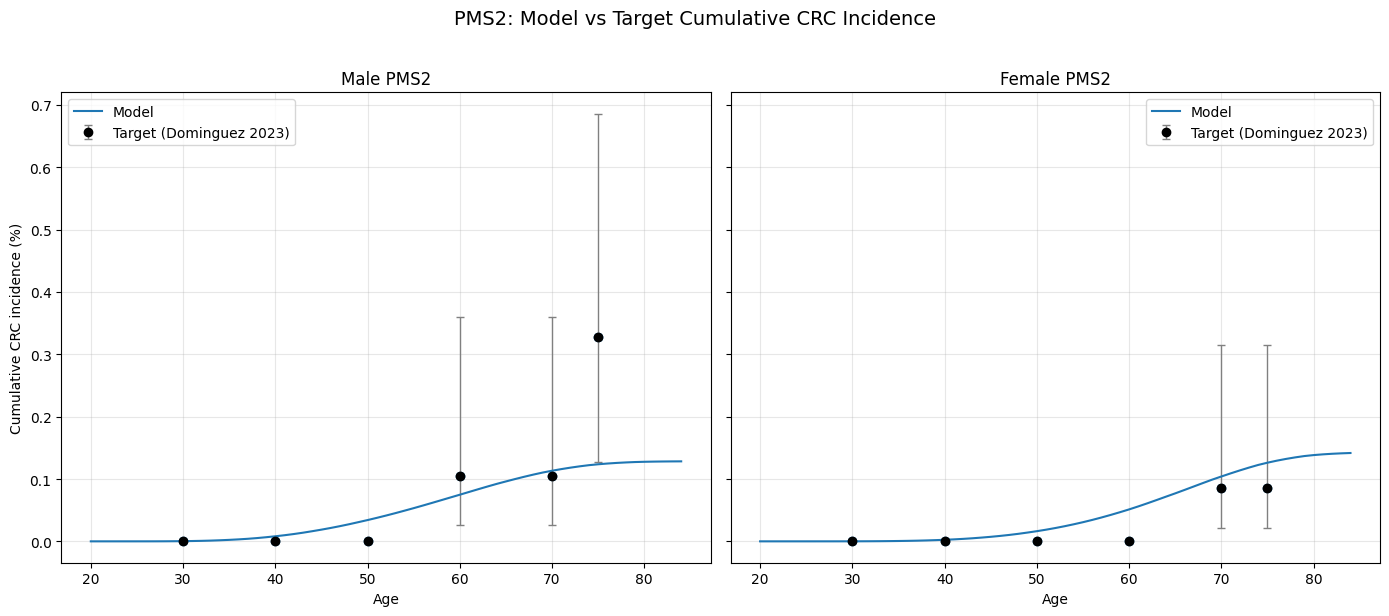

/Users/sophiewagner/repos/lynch-syndrome/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


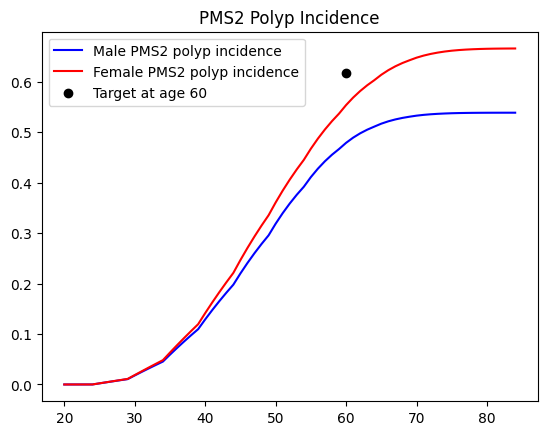

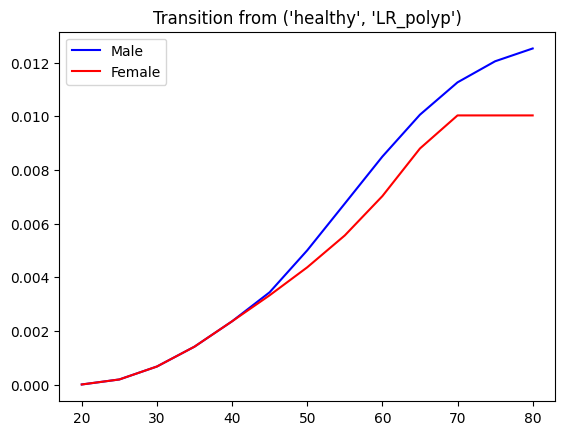

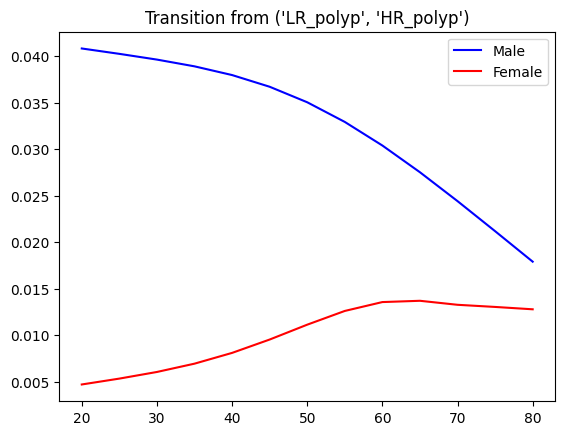

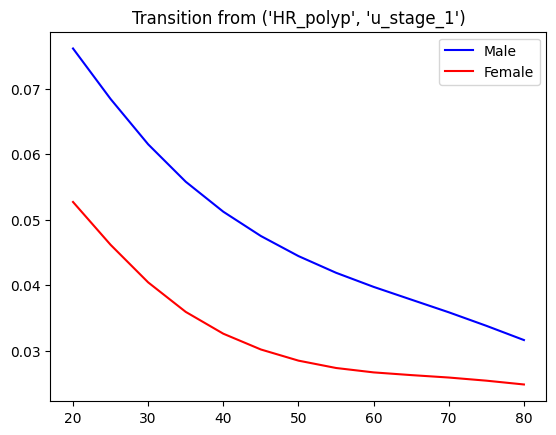

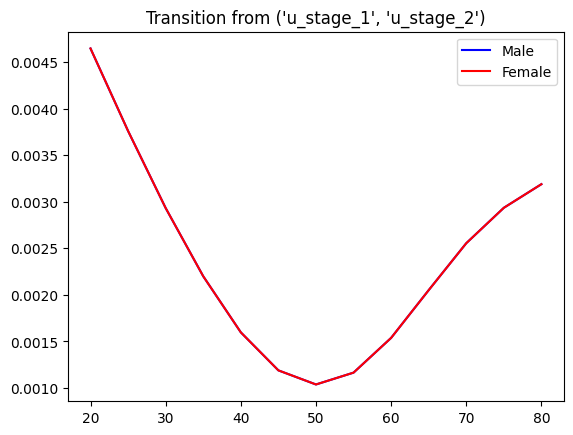

In [91]:
result_log = run_markov(result)
plot_crc_incidence(result_log, GENE)
plot_polyp_incidence(result_log, GENE)
plot_transition(result, (0,1))
plot_transition(result, (1,2))
plot_transition(result, (2,3))
plot_transition(result, (3,4))

In [93]:
print("Preclinical sojourn time (years)--------------------")
print(calc_preclinical_sojourn_time(result))

print("\nPolyp dwell time (years)--------------------------")
print(calc_total_polyp_dwell_time(result))

print("\n Stage distribution-------------------------------")
print(get_stage_dist(result_log))

print("\nTotal incidence-----------------------------------")
print(get_total_incidence(result_log))

print("\nPolyp incidence-----------------------------------")
print(get_polyp_inc(result_log))

Preclinical sojourn time (years)--------------------
        male     female
0  16.389404  19.313007

Polyp dwell time (years)--------------------------
       male     female
0  3.668543  10.235427

 Stage distribution-------------------------------
     stage1    stage2    stage3    stage4
0  0.459027  0.299237  0.152724  0.089012

Total incidence-----------------------------------
       male     female
0  12.83196  14.170785

Polyp incidence-----------------------------------
        male     female
0  53.852732  66.579185


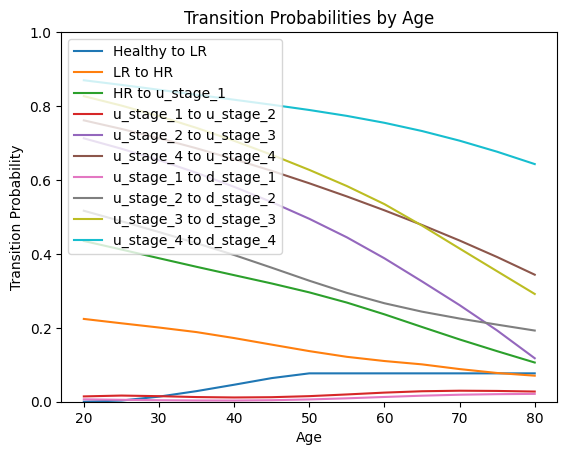

In [17]:
# Plot transition probabilities
tm = result[0,:,:,:]
h_lr = func.probtoprob(tm[:, 0, 1],12,1)
lr_hr = func.probtoprob(tm[:, 1, 2],12,1)
hr_u1 = func.probtoprob(tm[:, 2, 3],12,1)
u1_u2 = func.probtoprob(tm[:, 3, 4],12,1)
u2_u3 = func.probtoprob(tm[:, 4, 5],12,1)
u3_u4 = func.probtoprob(tm[:, 5, 6],12,1)
u1_d1 = func.probtoprob(tm[:, 3, 7],12,1)
u2_d2 = func.probtoprob(tm[:, 4, 8],12,1)
u3_d3 = func.probtoprob(tm[:, 5, 9],12,1)
u4_d4 = func.probtoprob(tm[:, 6, 10],12,1)

ages = list(c.AGE_LAYERS.keys())
plt.plot(ages, h_lr, label="Healthy to LR")
plt.plot(ages, lr_hr, label="LR to HR")
plt.plot(ages, hr_u1, label="HR to u_stage_1")
plt.plot(ages, u1_u2, label="u_stage_1 to u_stage_2")
plt.plot(ages, u2_u3, label="u_stage_2 to u_stage_3")
plt.plot(ages, u3_u4, label="u_stage_4 to u_stage_4")
plt.plot(ages, u1_d1, label="u_stage_1 to d_stage_1")
plt.plot(ages, u2_d2, label="u_stage_2 to d_stage_2")
plt.plot(ages, u3_d3, label="u_stage_3 to d_stage_3")
plt.plot(ages, u4_d4, label="u_stage_4 to d_stage_4")
plt.ylim(0,1)
plt.xlabel("Age")
plt.ylabel("Transition Probability")
plt.title("Transition Probabilities by Age")
plt.legend(loc="upper left")
plt.show()

In [74]:
np.save("../tmats/PMS2_20250929_1100.npy", result)